In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
from itertools import groupby
import datetime as dt

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

###  Event stamps ( array I )

### TOs and ITIs:

#### 7   = Time-out, no lever response choice in 10 sec
#### 19  = Time-out, no right lever response forced in 10 seconds
#### 20  = Time-out, no left lever response forced in 10 seconds

#### 16  = ITI over

### LPs:

#### 17  = Initial forced trial lever press right
#### 18  = Initial forced trial lever press left
#### 8   = Lever choice right
#### 9   = Lever choice left

#### 5   = Reinforcement delivery

### HEs:

#### 10  = Initial head entry in trial   **** IN VERSION 22_BERNSTEIN THIS IS SIMULATED AFTER 1 SECOND ** VERSION 23 REINSTATED
#### 11  = Subsequent head entries




-   1   = Rt lever response in FR (if FR greater than 1 otherwise see codes 8,9,17,18,21,22)
-   2   = Lt lever response (if FR greater than 1 otherwise see codes 8,9,17,18,21,22)
-   3   = Rewarded rt lever response
-   4   = Rewarded lt lever response
-   6   = Time-out, no initial head-entry in 10 sec   **** REMOVED FOR VERSION 22_BERNSTEIN ** REINSTATED VERSION 23
-   12  = Right lever press during time-out
-   13  = Left lever press during time-out
-   14  = Head entry during time-out
-   15  = Time-out over
-   21  = Forced trial right lever
-   22  = Forced trail left lever
-   23  = Choice trial
-   24  = Head entry during ITI
-   25  = ICS signal
-   26  = Extinction trial
-   27  = Time-out, no press in A(22) minutes
-   28  = Time-out, did not complete FR in A(21) minutes
-   100 = Session termination




Use os module to create list of data folders

In [3]:
path_1 = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape'

session_list_1 = os.listdir(path_1)
print(len(session_list_1))
session_list_1[0:5]

106


['Shape_1_682_190614',
 'Shape_1_683_190613',
 'Shape_1_684_190613',
 'Shape_1_685_190614',
 'Shape_1_686_190613']

In [4]:
file_paths = []
for file in session_list_1:
    file_path = path_1 + '/' + file
    file_paths.append(file_path)

print(len(file_paths))
file_paths[0:5]

106


['C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_1_682_190614',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_1_683_190613',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_1_684_190613',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_1_685_190614',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_1_686_190613']

In [5]:
def get_file_info(file_path_name):
    # takes in a file path, finds the date, animal_number, session and session number, saves each accordingly
    import re
    
    path_split = file_path_name.split('/')
    file_split = path_split[-1].split('_')
    
    for row in file_split:
        if re.search(r'^\d\d\d\d\d\d$', row):
            date = row
        if re.search(r'^\d\d\d$', row):
            animal_number = row
        if re.search(r'((F|f)orce)|((C|c)hoice)', row):
            sub_session = row
        if re.search(r'^\d$', row):
            session_num = row
    
    try:
        sub_session
    except:
        sub_session = np.nan
    
    session = str(file_split[0] + '_' + session_num)

    return date, animal_number, session, sub_session

In [6]:
def make_array_from_path (file_path_name):
    # takes in path, creates array (each row of array is a row from original med file)
    import numpy as np
    import pandas as pd
    
    data = pd.read_table(file_path_name)
    data_table = pd.DataFrame(data = data)
    data_array = data_table.values
    
    return data_array

In [7]:
def get_events_and_times(array, event_letter, time_letter):
    #takes in array and the letters Med PC program uses to signify an event_stamp and time_stamp; 
    #finds all event_stamps and corresponding time_stamps; creats pandas dataframe
    import re
    import numpy as np
    import pandas as pd

    i = 0
    event_data = []
    time_data = []
    while i < len(array):
        if re.search(str(event_letter + ':'), str(array[i])):
            i = i + 1
            while re.search('\[\'\ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    event_data.append(float(element))
                i = i + 1
        if re.search(str(time_letter + ':'), str(array[i])):
            i = i + 1
            while re.search('\[\'\ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    time_data.append(float(element))
                i = i + 1
        i = i + 1
    
    eandt = np.column_stack((event_data, time_data))
    es_et = pd.DataFrame(data = eandt)
    es_et.columns = ['event_stamp', 'time_stamp']
    
    return es_et

In [8]:
def get_trial_times_two(events_and_times, start_marker, ITI_marker, TO_rt_marker, TO_lt_marker, TO_choice_marker):
    #takes in dataframe of events and corresponding time_stamps and the Med PC program code for ITI mark of trial segment
    #e.g. conditioned stimulus onset and offset, ITI onset and offset
    #finds time_stamps for each start and end, puts into new dataframe
    import numpy as np
    import pandas as pd

    trial_starts = events_and_times[events_and_times['event_stamp'] == start_marker]['time_stamp'].values
    trial_ends = events_and_times[events_and_times['event_stamp'] == ITI_marker]['time_stamp'].values
    trial_lp_TOs = events_and_times[(events_and_times['event_stamp'] == TO_rt_marker) | (events_and_times['event_stamp'] == TO_lt_marker) | (events_and_times['event_stamp'] == TO_choice_marker)]['time_stamp'].values
    
    trial_ends_updated = np.sort(np.concatenate((trial_ends, trial_lp_TOs), axis=0))
    
    times = pd.DataFrame(data = [trial_starts, trial_ends_updated])
    times = times.T
    times.columns = ['trial_start', 'trial_end']
    
    return times

In [9]:
def create_trials_df(events_and_times, trial_times):
    
    i = 0
    trial_data = pd.DataFrame()
    
    while i < len(trial_times):
        data = events_and_times[(events_and_times['time_stamp'] >= trial_times['trial_start'][i]) & (events_and_times['time_stamp'] <= trial_times['trial_end'][i])]
        data['trial_#'] = [i+1]*len(data)
        data['trial_start'] = trial_times['trial_start'][i]
        data['trial_end'] = trial_times['trial_end'][i]
        trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
        i = i + 1
    
    return trial_data

In [10]:
def count(trial_data, bit):
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    count = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        count.append(len(data[data['event_stamp'] == bit]))
        i = i + 1
    
    return count

In [11]:
def latency(trial_data, bit):
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    latency_1st = []
    latency_ave = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        data = data[data['event_stamp'] == bit]
        if len(data) < 1:
            latency_1st.append(0.0)
            latency_ave.append(0.0)
        else:
            latency_1st.append((data['time_stamp'] - data['trial_start']).values[0]/100)
            latency_ave.append((data['time_stamp'] - data['trial_start']).values.mean()/100)
        i = i + 1
    
    return latency_1st, latency_ave

In [12]:
def create_session_df(trial_data, bit_dic):
    
    trials = len((trial_data['trial_#'].unique()))
    
    #get HE_wait times
    times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['trial_start'].unique(), trial_data.groupby('trial_#')['trial_end'].unique()])
    times_df = times_df.T
    
    i = 0
    HE_waits = []
    while i < times_df.shape[0]:
        if (i == 0) | (i == times_df.shape[0] - 1):
            HE_waits.append(np.nan)
            i += 1
        else:
            HE_wait = times_df.iloc[i]['trial_start'] - times_df.iloc[i-1]['trial_end']
            HE_waits.append(int(HE_wait/100))
            i += 1
    
    session_data = pd.DataFrame(index=np.arange(0,trials))

    for name, bit in bit_dic.items():
        session_data[str(name + '_count')] = count(trial_data, bit)
        session_data[str(name + '_latency_1st')], session_data[str(name + '_latency_ave_bit')] = latency(trial_data, bit)
    
    session_data['trial_num'] = np.arange(session_data.shape[0])
    session_data['HE_wait'] = HE_waits
    
    return session_data

In [13]:
%%time
final_data = pd.DataFrame()
bit_dic = {'reinforcement': 5, 'right_lever_choice': 8, 'left_lever_choice': 9, 'right_lever_force': 17, 'left_lever_force': 18, 'HE_trial': 11}

for file in file_paths:
    print(file)
    date, animal_number, session, sub_session = get_file_info(file)
    array = make_array_from_path(file)
    events_and_times = get_events_and_times(array, "I", "T")
    trial_times = get_trial_times_two(events_and_times, 10, 16, 19, 20, 7)
    trial_data = create_trials_df(events_and_times, trial_times)
    session_data = create_session_df(trial_data, bit_dic)
    session_data['date'] = [date]*(session_data.shape[0])
    session_data['animal_number'] = [animal_number]*(session_data.shape[0])
    session_data['session'] = [session]*(session_data.shape[0])
    session_data['sub_session'] = [sub_session]*(session_data.shape[0])
    
    final_data = pd.concat([final_data, session_data], axis = 0, ignore_index=True)

C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_1_682_190614
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_1_683_190613
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_1_684_190613
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_1_685_190614
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_1_686_190613
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_1_687_190614
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_1_688_190614
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_1_689_190617
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/proba

C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_3_choice_694_190617
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_3_choice_695_190617
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_3_choice_696_190617
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_3_choice_697_190617
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_3_choice_698_190618
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_3_choice_699_190618
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_3_force_682_190618
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_3_force_683_190617
C:/Users/Schindler

In [14]:
final_data.groupby('date')['session'].value_counts()

date    session
190613  Shape_1    397
190614  Shape_1    440
        Shape_2    353
190617  Shape_2    304
        Shape_3    287
        Shape_1    104
190618  Shape_4    361
        Shape_3    320
        Shape_2    113
Name: session, dtype: int64

In [15]:
final_data[final_data['session'] == 'Shape_4'].groupby(['session', 'animal_number']).mean()

reinforcement_count  reinforcement_latency_1st  reinforcement_latency_ave_bit  right_lever_choice_count  right_lever_choice_latency_1st  right_lever_choice_latency_ave_bit  left_lever_choice_count  left_lever_choice_latency_1st  left_lever_choice_latency_ave_bit  right_lever_force_count  right_lever_force_latency_1st  right_lever_force_latency_ave_bit  left_lever_force_count  left_lever_force_latency_1st  left_lever_force_latency_ave_bit  HE_trial_count  HE_trial_latency_1st  HE_trial_latency_ave_bit  trial_num    HE_wait
session animal_number                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
Shape_4 683                       0.911111                   3.120667                       3.120667                  0.200000                        0.693556                            0.693556                 0.266667                       0.571556                           0.571556                 0.222222                       0.897556                           0.897556                0.222222                      0.948889                          0.948889        1.111111              0.703111                  0.942648  10.755556   7.853659
        684                       0.955556                   1.891111                       1.891111                  0.133333                        0.204889                            0.204889                 0.333333                       0.578444                           0.578444                 0.244444                       0.688222                           0.688222                0.244444                      0.410000                          0.410000        0.866667              0.166000                  0.290426  10.755556   7.902439
        686                       0.893617                   2.924468                       2.924468                  0.255319                        0.610213                            0.610213                 0.234043                       0.804468                           0.804468                 0.212766                       0.806383                           0.806383                0.191489                      0.694468                          0.694468        1.382979              0.680426                  0.985723  11.255319   7.534884
        691                       0.931818                   3.735682                       3.735682                  0.181818                        0.588636                            0.588636                 0.295455                       1.207273                           1.207273                 0.204545                       0.797500                           0.797500                0.250000                      1.132955                          1.132955        0.363636              0.249545                  0.303561  10.500000  10.375000
        694                       0.955556                   2.328889                       2.328889                  0.355556                        0.647778                            0.647778                 0.155556                       0.300889                           0.300889                 0.222222                       0.850444                           0.850444                0.222222                      0.520222                          0.520222        0.800000              0.143111                  0.390348  10.800000   6.487805
        695                       0.727273                   1.237045                       1.237045                  0.000000                        0.000000        

In [16]:
final_data[final_data['session'] == 'Shape_4'].groupby('animal_number')['reinforcement_count'].count()

animal_number
683    45
684    45
686    47
691    44
694    45
695    44
696    47
697    44
Name: reinforcement_count, dtype: int64

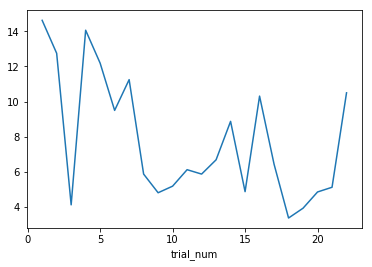

In [17]:
final_data[final_data['session'] == 'Shape_4'].groupby('trial_num')['HE_wait'].mean().plot()

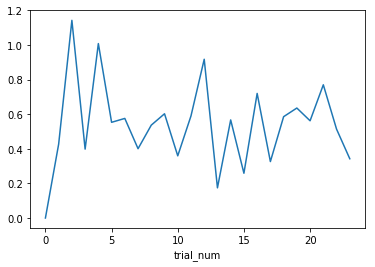

In [18]:
final_data[final_data['session'] == 'Shape_4'].groupby('trial_num')['right_lever_choice_latency_1st'].mean().plot()

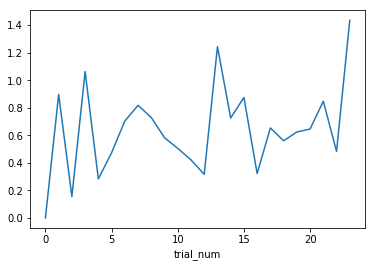

In [19]:
final_data[final_data['session'] == 'Shape_4'].groupby('trial_num')['left_lever_choice_latency_1st'].mean().plot()

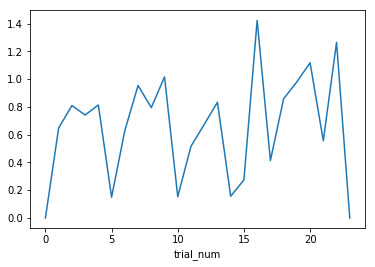

In [20]:
final_data[final_data['session'] == 'Shape_4'].groupby('trial_num')['right_lever_force_latency_1st'].mean().plot()

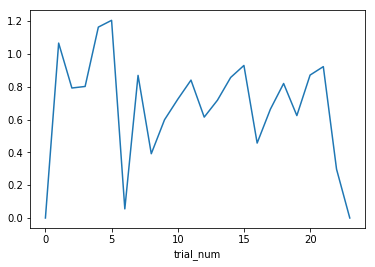

In [21]:
final_data[final_data['session'] == 'Shape_4'].groupby('trial_num')['left_lever_force_latency_1st'].mean().plot()

In [38]:
shape_4_mice = final_data[final_data['session'] == 'Shape_4']['animal_number'].unique()
lp_assign_df = final_data[final_data['animal_number'].isin(shape_4_mice)]
print(lp_assign_df['animal_number'].unique() == shape_4_mice)
lp_assign_df = lp_assign_df[['animal_number', 'session', 'date', 'right_lever_choice_count',
                             'left_lever_choice_count']]
lp_assign_df.head()

[ True  True  True  True  True  True  True  True]


,animal_number,session,date,right_lever_choice_count,left_lever_choice_count
44,683,Shape_1,190613,0,0
45,683,Shape_1,190613,1,0
46,683,Shape_1,190613,0,1
47,683,Shape_1,190613,1,0
48,683,Shape_1,190613,0,1


In [49]:
lp_assign_groupby = lp_assign_df.groupby(['animal_number', 'session']).sum()
lp_assign_groupby['lever_bias'] = lp_assign_groupby['right_lever_choice_count'] \
    / (lp_assign_groupby['right_lever_choice_count'] + lp_assign_groupby['left_lever_choice_count'])

In [71]:
lp_assign_groupby.groupby('animal_number')['lever_bias'].mean()

animal_number
683    0.685564
684    0.478649
686    0.498856
691    0.415781
694    0.508734
695    0.000000
696    0.793996
697    0.514732
Name: lever_bias, dtype: float64

In [60]:
lp_assign_groupby.iloc[lp_assign_groupby.index.get_level_values('session') == 'Shape_4']

,,right_lever_choice_count,left_lever_choice_count,lever_bias
animal_number,session,,,
683,Shape_4,9,12,0.428571
684,Shape_4,6,15,0.285714
686,Shape_4,12,11,0.521739
691,Shape_4,8,13,0.380952
694,Shape_4,16,7,0.695652
695,Shape_4,0,23,0.000000
696,Shape_4,19,4,0.826087
697,Shape_4,12,9,0.571429


In [72]:
#single file option for trouble shooting

file_path = file_paths[20]
print('file_path:', '\n', file_path, '\n')

date, animal_number, session, sub_session = get_file_info(file_path)
print('date:', date, 'animal_number:', animal_number, 'session:', session, 'sub_session:', sub_session, '\n')

array = make_array_from_path(file_path)
print(array)

events_and_times = get_events_and_times(array, "I", "T")
print(events_and_times.head(), '\n')

trial_times = get_trial_times_two(events_and_times, 10, 16, 19, 20, 7)
print(trial_times.head(), '\n')

trial_data = create_trials_df(events_and_times, trial_times)
print(trial_data.head(), '\n')

bit_dic = {'reinforcement': 5, 'right_lever_choice': 8, 'left_lever_choice': 9, 'right_lever_force': 17, 'left_lever_force': 18, 'HE_trial': 11}
session_data = create_session_df(trial_data, bit_dic)

file_path: 
 C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/shape/Shape_2_choice_682_190617 

date: 190617 animal_number: 682 session: Shape_2 sub_session: choice 

[['Start Date: 06/17/19']
 ['End Date: 06/17/19']
 ['Subject: 682']
 ['Experiment: 0']
 ['Group: 0']
 ['Box: 2']
 ['Start Time: 10:27:58']
 ['End Time: 10:56:29']
 ['MSN: Mark_forced_choice23_Bernstein_50_50_TTL']
 ['G:     131.000']
 ['H:  148378.000']
 ['K:       0.000']
 ['N:       1.000']
 ['O:       0.000']
 ['P:       0.000']
 ['Y:       0.000']
 ['Z:       0.000']
 ['A:']
 ['     0:        0.000       32.000        1.000        1.000        1.000']
 ['     5:        1.000        0.000        0.000       -1.000       60.000']
 ['    10:        2.000        0.000        0.000        0.000       25.000']
 ['    15:       25.000       25.000       24.000       30.000        3.000']
 ['    20:       12.000        5.000        1.000        2.000        0.000']
 ['    25:        0

   event_stamp  time_stamp  trial_#  trial_start  trial_end
0         10.0     11927.0        1      11927.0    15363.0
1         23.0     11928.0        1      11927.0    15363.0
2          9.0     12163.0        1      11927.0    15363.0
3          4.0     12164.0        1      11927.0    15363.0
4          5.0     12164.0        1      11927.0    15363.0 

